# 任务介绍

在这次练习中，我们需要实战Kaggle在两年前的一个比赛，狗的品种识别。链接在 https://www.kaggle.com/c/dog-breed-identification 。

在这个比赛中，我们需要使用训练数据，利用深度学习的方法，对测试集图像中的狗进行识别，比赛中狗的种类一共有120种。这个比赛的数据集实际上是著名的ImageNet的子集数据集。ImageNet 是一个计算机视觉系统识别的任务， 是目前世界上图像识别最大的数据库，总共有1000个类别。

下图展示了数据集中一些狗的示例。

![img](imgs/example.PNG)

## 开始之前

开始之前有以下的准备工作需要做：

1. 需要先在Kaggle上注册账号，然后点击 Late submission，表明同意比赛的规则，这时就可以下载数据集了。
2. 需要安装好Pytorch，Pytorch及GPU相关驱动的安装可以参考这个链接：https://blog.csdn.net/Barry_J/article/details/81079218 ；最好能在支持的GPU上面运行程序，可以节省很多的时间，如果没有GPU，直接用CPU跑当然也是可行的，这次任务需要的资源并不多。


通过本教程的学习，将对Python语言、数据竞赛、深度学习有更深刻的理解，具体来说，您将学到以下内容：

- 拿到一个比赛，如何读取比赛数据
- 读取到比赛数据后，如何定义、训练我们的模型，使它有更好的效果
- 如何评估我们模型的效果
- 有了模型以后，如何用它得到一个可以提交的结果
- 在Kaggle上从注册到完成一个比赛的整体流程

本教程中主要使用到的Python库以及它们的作用：

- Panda 数据表读取、写入，生成数据表
- PIL 打开图像
- Matplotlib 画柱状图、显示打开的图像
- Sklearn 分割数据集，将品种字段进行类别编码（编码为一个数）
- Pytorch 定义 dataset ，进行数据转换，加载预训练模型，修改模型结构，训练模型


## 数据相关操作

下载好的数据包含两个文件夹和一个文件，`test`, `train`和`labels.csv`，其中`train`里包含我们训练模型需要用到的数据，`test`中包含最后需要提交上去测试结果的图片，`labels.csv`中包含训练数据对应的标签，他们是通过文件名来对应的。

先导入一些之后会用到的库

In [57]:
# 如果除了pytorch提示有库不存在，可以运行以下的命令
# !pip install pillow
# !pip install tqdm
# !pip install pandas
# !pip install scipy sklearn

In [1]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from torchvision import transforms
import torchvision
from torch.autograd import Variable
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
from tqdm import tqdm

因为给定的标签是csv格式的，我们首先得通过 `pandas` 来读出训练集中所有图像的类别，以及所有的文件名。

**这里需要将`data_dir`修改为存储数据的路径。**

In [2]:
data_dir = "E:/data/dog-breed-identification/"
csv_path = os.path.join(data_dir, 'labels.csv')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
assert os.path.exists(csv_path)
# 如果 assert 报错，检查一下数据的路径！

train_csv = pd.read_csv(csv_path)
train_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### 数据分析

首先打开几幅图试一下

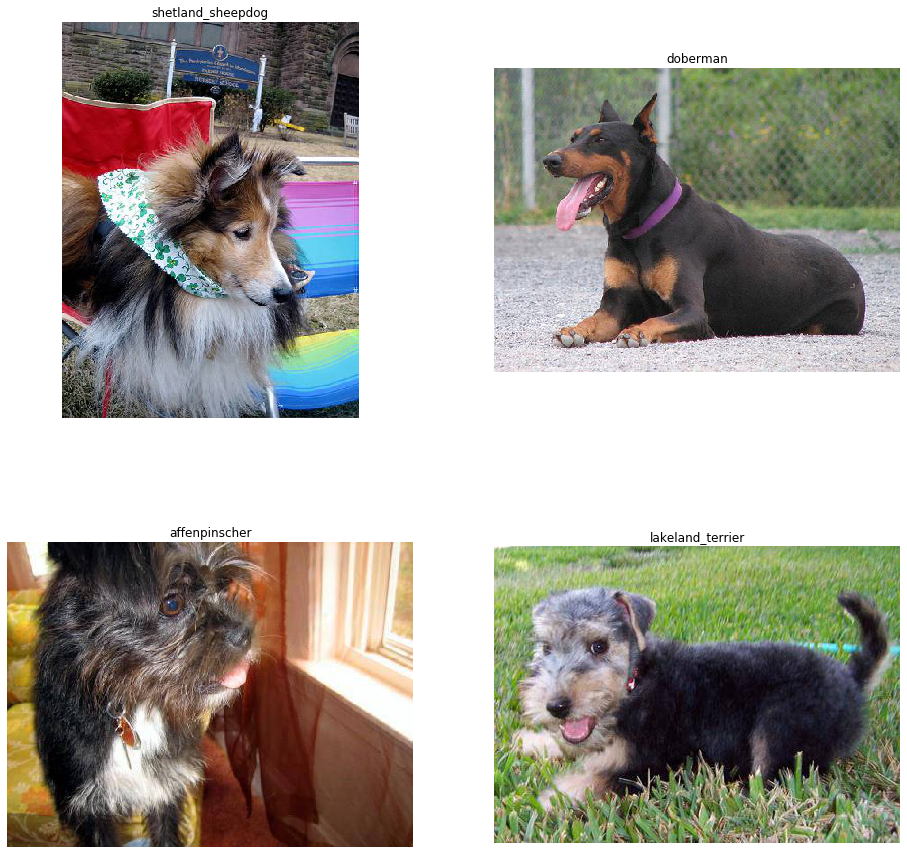

In [20]:
# 打开哪四幅
show = [10, 20, 30, 40]
pos = [221, 222, 223, 224]

fig = plt.figure(figsize=(16, 16))
for i in range(len(show)):
    ax = fig.add_subplot(pos[i])
    plt.axis('off')
    plt.title(train_csv.iloc[show[i], 1])
    img_path = os.path.join(train_dir, train_csv.iloc[show[i], 0] + '.jpg')
    plt.imshow(Image.open(img_path))

plt.show()

看一看每个类别分别有多少个数据

Text(0, 0.5, 'Number of Class')

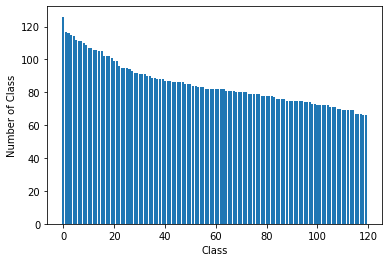

In [56]:
count = train_csv['breed'].value_counts()
count
plt.bar(range(120), count)
plt.xlabel("Class")
plt.ylabel("Number of Class")

数据中一共有120个种类，可以从柱状图中看出每个种类分布较为均衡，不需要使用一些专门的方法来处理数据不均衡。

### 数据处理

可以看到，id是图像的名字，breed是这个图像对应狗的品种。接下来我们需要将品种映射到一个类别的标签（数字），通过 sklearn 中的标签编码来实现。

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing.label import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(train_csv.breed)
print("映射后的标签", labels)
print("训练集的大小", labels.shape)

映射后的标签 [19 37 85 ...  3 75 28]
训练集的大小 (10222,)


为了验证我们模型的表现效果，我们需要从训练数据中随机划分个验证集出来，通过`sklearn.model_selection.train_test_split`可以很方便的做到这一点，参数中的`test_size`控制了选择多少比例的数据作为验证集，这里取了0.1。

In [5]:
filenames = train_csv.id.values
filenames_train, filenames_val, labels_train, labels_val = \
    train_test_split(filenames, labels, test_size=0.1, stratify=labels)
print("训练数据数", len(filenames_train))
print("验证数据数", len(filenames_val))

训练数据数 9199
验证数据数 1023


然后定义一下数据集DataSet类，通过这个 DataSet 以及之后的 DataLoader 可以很方便的利用到 Pytorch 的特性，来并行化的读取数据，最简单的DataSet类的实现，需要实现以下几个成员函数：`__init__`来进行这个数据集的初始化，定义一些与数据集相关的参数；`__len__`通过这个函数返回数据集的大小；`__getitem__`是最重要的一个函数，需要通过这个函数利用数据索引来得到所对应的数据。

以下是DataSet需要实现的代码框架

```python
class CustomDataset(data.Dataset):#继承自 data.Dataset
    def __init__(self):
        # TODO
        # 1. Initialize file path or list of file names.
        pass
    def __getitem__(self, index):
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        # 2. Preprocess the data (e.g. torchvision.Transform).
        # 3. Return a data pair (e.g. image and label).
        #
        pass
    def __len__(self):
        # You should change 0 to the total size of your dataset.
        return 0

```

Dataset类是读入数据集数据并且对读入的数据进行了索引。但是光有这个功能是不够的，由于现在我们处理的数据量一般都很大，还需要以下的几个功能

- 得到批量的数据，一批一批送到网络
- 由于读取数据是一个很耗费CPU的过程，而且现在CPU基本都是多核的，需要有效利用起来，所以需要有并行读取数据的功能
- 需要能够将数据随机重组，由于训练集可能有人为收集数据时留下的顺序信息，这个信息会影响到模型有效学习特征，需要将训练数据随机读取，这个如果自己每次都要实现会很麻烦。测试集一般不需要随机操作。



这时候就需要Dataloader类了，它为我们提供的常用操作有：batch_size(每个batch的大小), shuffle(是否进行shuffle操作), num_workers(加载数据的时候使用几个子进程)。Dataloader这个类并不需要我们自己设计代码，我们只需要利用DataLoader类读取我们设计好的Dataset子类即可：

```python
    # 利用dataloader读取我们的数据对象，并设定batch-size和工作进程
    loader = DataLoader(train_dataset, batch_size=16, num_workers=4, shuffle=True)
```


在接下来的代码中，我们来定义狗的品种这个数据集，它需要初始化的是`filenames`, `labels`, `root_dir`和`transform`，其中`filenames`是一个python的list，里面存放数据集中的图片名，`labels`是这些图片对应的标签，`root_dir`是这些数据存放的路径，train的数据存放在`train`文件夹下，test的数据存放在`test`文件夹下，`transform`会在后续进行说明。

In [6]:
class DogDataset(Dataset):
    """Dog Breed Dataset"""

    def __init__(self, filenames, labels, root_dir, transform=None):
        assert len(filenames) == len(labels)
        self.filenames = filenames
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        label = self.labels[item]
        img_name = os.path.join(self.root_dir, self.filenames[item] + '.jpg')

        with Image.open(img_name) as f:
            img = f.convert('RGB')

        if self.transform:
            img = self.transform(img)

        if self.labels is None:
            return img, self.filenames[item]
        else:
            return img, self.labels[item]

现在的神经网络都设计的越来越深，有很强的拟合能力，一般来说，为了避免我们的神经网络对训练数据过拟合，即单纯是把所有的训练数据都记住，然后给出一个结果，我们可以在训练的时候对数据做很多随机的操作，来避免这种现象。常见的随机操作有：

- 随机裁剪，先将图像放大一点，然后在随机的一个位置裁剪出来指定大小的图像
- 随机旋转和翻转图像，因为一个狗的照片镜像或者旋转一下还是一个狗，所以可以通过随机翻转的方法来避免过拟合
- 图像标准化，在计算机中存储图像一般是8位无符号数，直接在图像上进行学习比较困难，需要将其归一化到(0,1)范围内，这样可以加快网络的收敛速度


可以把`transform`当作一个“函数”，它的输入可以是一个图像数据，输出可以是我们提前设计的处理后的Tensor。

Pytorch 中关于`transform`的更多介绍可以参考：https://blog.csdn.net/u011995719/article/details/85107009

接下来的代码中，我们分别定义训练集和验证集对应的 `transform`。其中训练集用到了以下的`transform`：

1. `RandomResizedCrop`：随机将图像放大然后进行裁剪
2. `RandomHorizontalFlip`：随机将图像镜像翻转
3. `ToTensor`：将图像转化为pytorch的tensor
4. `Normalize`：将图像归一化到给定的均值和标准差下

验证集用到了以下的`transform`：

1. `Resize`：由于网络输入是给定的，通过这一步确保输入图像的大小与网络输入匹配
2. `ToTenser`：将图像转化为pytorch的tensor
3. `Normalize`：将图像归一化到给定的均值和标准差下

确定好了要进行的操作以后，通过`torchvision.transform`来将这几种操作合起来，得到一个完整的操作。

In [7]:
train_transform = transforms.Compose([transforms.RandomResizedCrop(224, scale=(0.75, 1)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                                ])
val_transform = transforms.Compose([transforms.Resize([224, 224]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                                ])

定义好 `transform` 以后，我们就可以实例化我们的 `dataset`，然后通过 `torch.utils.data.DataLoader` 得到一个可以迭代的对象来批量并行读取我们的数据。

In [8]:
batch_size = 32

train_dataset = DogDataset(filenames_train, labels_train, train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = DogDataset(filenames_val, labels_val, train_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(len(train_dataset))
print(len(val_dataset))

9199
1023


## 模型相关操作

将数据都准备好以后，需要准备我们的模型。

在本次任务中，我们将采用迁移学习中的模型迁移，迁移学习是通过从已学习的相关任务中转移知识来改善新任务的学习。在很多时候我们由于数据量或者计算资源的限制，从头开始训练一个网络是不现实的，比如这次任务中用到的网络。这时，使用迁移学习是一个很不错的选择。

迁移学习是通过将别人提前训练好的模型迁移到我们任务上来提升我们模型的性能。这个提前训练好的模型叫做预训练模型，Pytorch提供了很多预训练模型，这里我们使用在 ImageNet 上的预训练模型`resnet50`，它的网络结构如下图所示。

![img](imgs/resnet.png)

关于深度残差网络的详细信息，可以参考它的论文 https://arxiv.org/abs/1512.03385

通过以下的方式在 Pytorch 得到预训练的模型。这边我们把前面所有层的权重都固定，然后把最后的一层全连接层改成这里狗的品种数，只学习最后一层全连接层。

In [9]:
n_class = 120 # 总共有120种的狗
net = torchvision.models.resnet50(pretrained=True) # 得到预训练模型
for param in net.parameters():
    param.requires_grad = False # 固定住所有的权重
net.fc = torch.nn.Linear(2048, n_class) # 将最后的全连接层改掉

这样就定义好了我们的网络，接下来可以进行对这个网络进行训练了，训练神经网络有以下两个要素：

1. 损失函数：网络需要优化的目标，我们的目的就是通过网络的学习尽可能让损失函数更小。这边使用多分类中很常用到的交叉熵损失。交叉熵刻画的是两个概率分布之间的距离，越小说明网络的输出与真实的结果越接近。损失函数在 torch.nn 下定义了很多常见的损失函数。
2. 优化器：为了优化我们的神经网络，加快训练的速度，需要使用一些优化的策略。在pytorch中提供了torch.optim方法优化我们的神经网络，torch.optim是实现各种优化算法的包。一般来说直接使用这些优化器就可以了，没有必要定义自己的优化器。

In [10]:
criterion = torch.nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = torch.optim.Adam(net.fc.parameters(), lr=0.0001)  # 学习率为0.0001的Adam优化器

定义好了优化器和损失函数以后，我们就可以进行网络的学习了，接下来定义一个通用的学习函数，通过这个函数可以进行一轮网络的学习，它有以下几个参数：

- `net`：我们需要学习的网络
- `data_iter`：可以迭代的 DataLoader
- `criterion`：loss函数
- `use_cuda`：是否使用 GPU 加速训练

In [11]:
def train_epoch(net, data_iter, criterion, optimizer, use_cuda, print_every=50):
    net.train()
    correct = 0
    for batch_idx, (x, y) in tqdm(enumerate(data_iter)):
        if use_cuda:
            x, y = x.cuda(), y.cuda()
        x = Variable(x)
        y = Variable(y)
        optimizer.zero_grad()
        logits = net(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        prediction = torch.argmax(logits, 1)
        cur_correct = (prediction == y).sum().float()
        cur_accuracy = cur_correct / x.shape[0]
        correct += cur_correct

        if batch_idx % print_every == 0:
            print('current batch: {}/{} ({:.0f}%)\tLoss: {:.6f}\tAcc: {:.6f}'.format(
                batch_idx, len(data_iter),
                100. * batch_idx / len(data_iter), loss.data.item(), cur_accuracy))

    accuracy = correct / len(data_iter.dataset)
    print('Train epoch Acc: {:.6f}'.format(accuracy))
    return accuracy

类似地，我们可以定义验证的过程，在每次训练完一轮网络后验证我们模型的效果，这样可以提前将网络训练过程停止，防止在训练集上发生过拟合。

In [12]:
def val_epoch(net, data_iter, criterion, use_cuda):
    test_loss = 0
    correct = 0
    net.eval() # 将网络设置为验证的模式，不会改变参数
    for batch_idx, (x, y) in tqdm(enumerate(data_iter)):
        if use_cuda:
            x, y = x.cuda(), y.cuda()
        x = Variable(x)
        y = Variable(y)
        logits = net(x)
        loss = criterion(logits, y)

        test_loss += loss.data.item()
        prediction = torch.argmax(logits, 1)
        cur_correct = (prediction == y).sum().float()
        correct += cur_correct

    test_loss /= len(data_iter.dataset)
    accuracy = correct / len(data_iter.dataset)

    print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, correct, len(data_iter.dataset), 100. * accuracy))

    return accuracy

定义好训练过程和验证过程以后，我们可以设置一些训练时的参数。

In [13]:
EPOCHS = 10 # 设置网络迭代最多10次
use_cuda = torch.cuda.is_available() # 查看是否有 GPU 可用
print(use_cuda)

True


In [14]:
if use_cuda:
    net.cuda() # 将网络搬到 GPU 上

state = {}
state['val_acc'] = []
state['best_val_acc'] = 0
state['lives'] = 4

for epoch in range(EPOCHS):
    print("Epoch: ", epoch+1)
    train_acc = train_epoch(net, train_loader, criterion, optimizer, use_cuda)
    print("Evaluating...")
    val_acc = val_epoch(net, val_loader, criterion, use_cuda)

    state['val_acc'].append(val_acc)
    if val_acc > state['best_val_acc']:
        state['lives'] = 4
        state['best_val_acc'] = val_acc
    else:
        state['lives'] -= 1
        print("Trial left :", state['lives'])
        if state['lives'] == 2:
            optimizer.param_groups[0]['lr'] /= 2
        if state['lives'] == 0:
            break

Epoch:  1


0it [00:00, ?it/s]

current batch: 0/288 (0%)	Loss: 4.824439	Acc: 0.000000


50it [00:15,  3.52it/s]

current batch: 50/288 (17%)	Loss: 4.486506	Acc: 0.062500


100it [00:30,  3.42it/s]

current batch: 100/288 (35%)	Loss: 4.073093	Acc: 0.281250


150it [00:45,  3.43it/s]

current batch: 150/288 (52%)	Loss: 3.848574	Acc: 0.312500


200it [01:00,  3.37it/s]

current batch: 200/288 (69%)	Loss: 3.598921	Acc: 0.406250


250it [01:16,  3.28it/s]

current batch: 250/288 (87%)	Loss: 3.164575	Acc: 0.562500


288it [01:27,  3.49it/s]


Train epoch Acc: 0.336341
Evaluating...


32it [00:14,  2.18it/s]



Val set: Average loss: 0.0906, Accuracy: 656.0/1023 (64%)

Epoch:  2


0it [00:00, ?it/s]

current batch: 0/288 (0%)	Loss: 2.870648	Acc: 0.718750


50it [00:14,  3.44it/s]

current batch: 50/288 (17%)	Loss: 2.784112	Acc: 0.562500


100it [00:29,  3.50it/s]

current batch: 100/288 (35%)	Loss: 2.447611	Acc: 0.750000


150it [00:44,  3.27it/s]

current batch: 150/288 (52%)	Loss: 2.257046	Acc: 0.781250


200it [00:59,  3.52it/s]

current batch: 200/288 (69%)	Loss: 2.530027	Acc: 0.468750


250it [01:14,  3.52it/s]

current batch: 250/288 (87%)	Loss: 1.859881	Acc: 0.781250


288it [01:25,  3.26it/s]


Train epoch Acc: 0.696706
Evaluating...


32it [00:15,  2.05it/s]



Val set: Average loss: 0.0575, Accuracy: 792.0/1023 (77%)

Epoch:  3


0it [00:00, ?it/s]

current batch: 0/288 (0%)	Loss: 1.826648	Acc: 0.781250


50it [00:15,  3.05it/s]

current batch: 50/288 (17%)	Loss: 1.990918	Acc: 0.656250


100it [00:31,  3.25it/s]

current batch: 100/288 (35%)	Loss: 1.610246	Acc: 0.812500


150it [00:46,  3.30it/s]

current batch: 150/288 (52%)	Loss: 1.297879	Acc: 0.875000


200it [01:01,  3.40it/s]

current batch: 200/288 (69%)	Loss: 1.527655	Acc: 0.687500


250it [01:17,  3.44it/s]

current batch: 250/288 (87%)	Loss: 1.392835	Acc: 0.906250


288it [01:28,  3.48it/s]


Train epoch Acc: 0.781389
Evaluating...


32it [00:15,  2.12it/s]



Val set: Average loss: 0.0418, Accuracy: 822.0/1023 (80%)

Epoch:  4


0it [00:00, ?it/s]

current batch: 0/288 (0%)	Loss: 1.300671	Acc: 0.937500


50it [00:14,  3.20it/s]

current batch: 50/288 (17%)	Loss: 1.494518	Acc: 0.750000


100it [00:29,  3.31it/s]

current batch: 100/288 (35%)	Loss: 1.189296	Acc: 0.750000


150it [00:44,  3.03it/s]

current batch: 150/288 (52%)	Loss: 1.299743	Acc: 0.781250


200it [01:02,  3.14it/s]

current batch: 200/288 (69%)	Loss: 1.057744	Acc: 0.875000


250it [01:23,  1.19s/it]

current batch: 250/288 (87%)	Loss: 1.294360	Acc: 0.875000


288it [01:56,  1.41it/s]


Train epoch Acc: 0.819437
Evaluating...


32it [00:20,  2.03it/s]



Val set: Average loss: 0.0338, Accuracy: 842.0/1023 (82%)

Epoch:  5


0it [00:00, ?it/s]

current batch: 0/288 (0%)	Loss: 1.141766	Acc: 0.781250


50it [00:14,  3.50it/s]

current batch: 50/288 (17%)	Loss: 1.076124	Acc: 0.812500


100it [00:29,  3.40it/s]

current batch: 100/288 (35%)	Loss: 0.993151	Acc: 0.781250


150it [00:44,  3.52it/s]

current batch: 150/288 (52%)	Loss: 0.975610	Acc: 0.843750


200it [01:00,  3.28it/s]

current batch: 200/288 (69%)	Loss: 1.034346	Acc: 0.812500


250it [01:18,  2.05it/s]

current batch: 250/288 (87%)	Loss: 0.829164	Acc: 0.875000


288it [01:30,  3.32it/s]


Train epoch Acc: 0.834656
Evaluating...


32it [00:17,  2.03it/s]



Val set: Average loss: 0.0295, Accuracy: 842.0/1023 (82%)

Trial left : 3
Epoch:  6


0it [00:00, ?it/s]

current batch: 0/288 (0%)	Loss: 0.802707	Acc: 0.937500


50it [00:15,  3.31it/s]

current batch: 50/288 (17%)	Loss: 0.829393	Acc: 0.812500


100it [00:31,  3.32it/s]

current batch: 100/288 (35%)	Loss: 1.208802	Acc: 0.718750


150it [00:47,  3.16it/s]

current batch: 150/288 (52%)	Loss: 1.024642	Acc: 0.812500


200it [01:02,  3.52it/s]

current batch: 200/288 (69%)	Loss: 0.783935	Acc: 0.937500


250it [01:18,  3.41it/s]

current batch: 250/288 (87%)	Loss: 1.068012	Acc: 0.812500


288it [01:29,  3.44it/s]


Train epoch Acc: 0.842265
Evaluating...


32it [00:15,  2.10it/s]



Val set: Average loss: 0.0259, Accuracy: 846.0/1023 (83%)

Epoch:  7


0it [00:00, ?it/s]

current batch: 0/288 (0%)	Loss: 0.878342	Acc: 0.906250


50it [00:14,  3.43it/s]

current batch: 50/288 (17%)	Loss: 0.619036	Acc: 0.843750


100it [00:29,  3.52it/s]

current batch: 100/288 (35%)	Loss: 0.482031	Acc: 0.906250


150it [00:44,  3.41it/s]

current batch: 150/288 (52%)	Loss: 0.954733	Acc: 0.812500


200it [00:59,  3.31it/s]

current batch: 200/288 (69%)	Loss: 0.923392	Acc: 0.843750


250it [01:14,  3.52it/s]

current batch: 250/288 (87%)	Loss: 0.843607	Acc: 0.781250


288it [01:25,  3.52it/s]


Train epoch Acc: 0.850853
Evaluating...


32it [00:16,  1.72it/s]



Val set: Average loss: 0.0244, Accuracy: 842.0/1023 (82%)

Trial left : 3
Epoch:  8


0it [00:00, ?it/s]

current batch: 0/288 (0%)	Loss: 0.777255	Acc: 0.750000


50it [00:15,  3.52it/s]

current batch: 50/288 (17%)	Loss: 0.638843	Acc: 0.937500


100it [00:29,  3.52it/s]

current batch: 100/288 (35%)	Loss: 1.013759	Acc: 0.843750


150it [00:45,  3.02it/s]

current batch: 150/288 (52%)	Loss: 0.778521	Acc: 0.843750


200it [01:02,  3.48it/s]

current batch: 200/288 (69%)	Loss: 0.496273	Acc: 0.906250


250it [01:17,  3.29it/s]

current batch: 250/288 (87%)	Loss: 0.879535	Acc: 0.843750


288it [01:28,  3.52it/s]


Train epoch Acc: 0.857702
Evaluating...


32it [00:16,  2.06it/s]



Val set: Average loss: 0.0228, Accuracy: 845.0/1023 (83%)

Trial left : 2
Epoch:  9


0it [00:00, ?it/s]

current batch: 0/288 (0%)	Loss: 0.850727	Acc: 0.812500


50it [00:14,  3.33it/s]

current batch: 50/288 (17%)	Loss: 0.808239	Acc: 0.812500


100it [00:30,  3.41it/s]

current batch: 100/288 (35%)	Loss: 0.666387	Acc: 0.906250


150it [00:45,  3.39it/s]

current batch: 150/288 (52%)	Loss: 0.584305	Acc: 0.906250


200it [01:00,  3.20it/s]

current batch: 200/288 (69%)	Loss: 0.518936	Acc: 0.906250


250it [01:18,  2.08it/s]

current batch: 250/288 (87%)	Loss: 0.481750	Acc: 0.875000


288it [01:31,  3.47it/s]


Train epoch Acc: 0.866399
Evaluating...


32it [00:15,  2.09it/s]



Val set: Average loss: 0.0220, Accuracy: 858.0/1023 (84%)

Epoch:  10


0it [00:00, ?it/s]

current batch: 0/288 (0%)	Loss: 0.666481	Acc: 0.843750


50it [00:14,  3.45it/s]

current batch: 50/288 (17%)	Loss: 0.814521	Acc: 0.812500


100it [00:30,  3.36it/s]

current batch: 100/288 (35%)	Loss: 0.594635	Acc: 0.875000


150it [00:45,  3.19it/s]

current batch: 150/288 (52%)	Loss: 0.428024	Acc: 0.937500


200it [01:00,  3.33it/s]

current batch: 200/288 (69%)	Loss: 0.513066	Acc: 0.906250


250it [01:14,  3.24it/s]

current batch: 250/288 (87%)	Loss: 0.677388	Acc: 0.843750


288it [01:26,  3.47it/s]


Train epoch Acc: 0.872921
Evaluating...


32it [00:15,  2.09it/s]



Val set: Average loss: 0.0217, Accuracy: 861.0/1023 (84%)



可以看到，最后网络在训练集上的精度是 0.872921,在验证集上的精度是 0.84。

有了这个网络以后，我们就可以将测试集的数据送到我们的网络，跑出测试集的结果然后去 Kaggle 上提交结果。

先看一下我们提交结果的形式

In [18]:
sample_result = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))
print(sample_result.shape)
sample_result.head(5)

(10357, 121)


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


这次比赛使用的是`logloss`来评估我们模型的结果，我们需要提交测试集中每一张图片对于所有类别的预测结果。



In [20]:
# test 的数据集定义

test_dataset = DogDataset(sample_result.id, labels=[0 for i in range(len(sample_result.id))], root_dir = test_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(test_dataset))

10357


In [21]:
net.eval()

# 定义Softmax，将输出缩放为概率的形式
softmax = torch.nn.Softmax()

first = True
total_batch = int(len(test_dataset) / batch_size)
for batch_idx, (x, y) in enumerate(test_loader):
    print("{} / {}".format(batch_idx, total_batch))
    if use_cuda:
        x, y = x.cuda(), y.cuda()
    x = Variable(x)
    y = Variable(y)
    prediction = softmax(net(x)).detach().cpu().numpy()
    if first:
        results = prediction
        first = False
    else:
        results = np.concatenate((results, prediction), axis=0)

0 / 323


C:\Users\P51\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


1 / 323
2 / 323
3 / 323
4 / 323
5 / 323
6 / 323
7 / 323
8 / 323
9 / 323
10 / 323
11 / 323
12 / 323
13 / 323
14 / 323
15 / 323
16 / 323
17 / 323
18 / 323
19 / 323
20 / 323
21 / 323
22 / 323
23 / 323
24 / 323
25 / 323
26 / 323
27 / 323
28 / 323
29 / 323
30 / 323
31 / 323
32 / 323
33 / 323
34 / 323
35 / 323
36 / 323
37 / 323
38 / 323
39 / 323
40 / 323
41 / 323
42 / 323
43 / 323
44 / 323
45 / 323
46 / 323
47 / 323
48 / 323
49 / 323
50 / 323
51 / 323
52 / 323
53 / 323
54 / 323
55 / 323
56 / 323
57 / 323
58 / 323
59 / 323
60 / 323
61 / 323
62 / 323
63 / 323
64 / 323
65 / 323
66 / 323
67 / 323
68 / 323
69 / 323
70 / 323
71 / 323
72 / 323
73 / 323
74 / 323
75 / 323
76 / 323
77 / 323
78 / 323
79 / 323
80 / 323
81 / 323
82 / 323
83 / 323
84 / 323
85 / 323
86 / 323
87 / 323
88 / 323
89 / 323
90 / 323
91 / 323
92 / 323
93 / 323
94 / 323
95 / 323
96 / 323
97 / 323
98 / 323
99 / 323
100 / 323
101 / 323
102 / 323
103 / 323
104 / 323
105 / 323
106 / 323
107 / 323
108 / 323
109 / 323
110 / 323
111 / 32

In [22]:
results.shape

(10357, 120)

In [23]:
df = pd.DataFrame(data=results, index=sample_result.id, columns=le.classes_)
df.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
id,,,,,,,,,,,,,,,,,,,,,
000621fb3cbb32d8935728e48679680e,0.000036,0.003434,0.000008,0.000010,0.000012,0.000033,3.316232e-05,9.783248e-05,0.000095,0.000301,...,0.000103,0.000056,0.000019,0.000076,0.000021,0.000241,0.000033,0.000100,0.000066,0.000158
00102ee9d8eb90812350685311fe5890,0.000005,0.000006,0.000001,0.000001,0.000025,0.000040,2.432131e-05,4.889337e-05,0.000010,0.000003,...,0.000067,0.000021,0.000003,0.000009,0.000003,0.000008,0.000533,0.000003,0.000015,0.000004
0012a730dfa437f5f3613fb75efcd4ce,0.000001,0.003933,0.000005,0.000023,0.000004,0.000011,8.445907e-07,8.160892e-07,0.000100,0.000014,...,0.000003,0.000008,0.000006,0.000248,0.000053,0.004516,0.000013,0.000359,0.000035,0.000011
001510bc8570bbeee98c8d80c8a95ec1,0.070168,0.003006,0.000581,0.003060,0.006820,0.004348,7.603069e-04,2.698609e-03,0.002990,0.001681,...,0.006677,0.000997,0.000992,0.001750,0.001878,0.002578,0.000809,0.010422,0.000844,0.005235
001a5f3114548acdefa3d4da05474c2e,0.007039,0.003949,0.000487,0.000429,0.000265,0.000268,1.850218e-03,1.909158e-04,0.001098,0.000247,...,0.003087,0.000204,0.000113,0.000676,0.000137,0.000888,0.005376,0.000265,0.003620,0.001196


In [24]:
df.to_csv("submit.csv")

得到结果以后可以去 Kaggle 网站提交结果：https://www.kaggle.com/c/dog-breed-identification/submissions

应该会拿到排名在60%的成绩，由于这次做的比较基础，并且也没有用到多个模型的融合，所以效果还有很大的进步空间。

感谢您的阅读，加油！